In [ ]:
!git clone https://github.com/LeoisWTT/PHYS3151-Machine-Learning-in-Physics-2023

## 1. PCA and Clustering on 2D ferromagnetic Ising model

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [2]:
# spin configurations
df1 = pd.read_csv(
    "./PHYS3151-Machine-Learning-in-Physics-2023/principal-component-analysis/Ising_model/conf.csv", header=None)
# temperature
df2 = pd.read_csv(
    "./PHYS3151-Machine-Learning-in-Physics-2023/principal-component-analysis/Ising_model/temp.csv", header=None)
df1 = df1.to_numpy()
df2 = df2.to_numpy()
x = df1
t = df2
t = t.T


### (a) Perform PCA to the data

We project the data onto the first **three** components. And plot our dimensionally reduced data.

In [3]:
from numpy import linalg as la

z = np.zeros(x.shape)
x_mean = np.mean(x, axis=0)
x_std = np.std(x, axis=0, ddof=0)
for i in range(100):
    z[:, i] = (x_mean[i]-x[:, i])

cov = np.cov(z, rowvar=False)
U, sigma, VT = la.svd(cov)


In [4]:
def reduce_system(U, dimension):
    U_reduced = U[:, :dimension]
    reduced_vec = np.dot(z, U_reduced)
    var = np.sum(sigma[:dimension])/np.sum(sigma[:])
    return reduced_vec, var


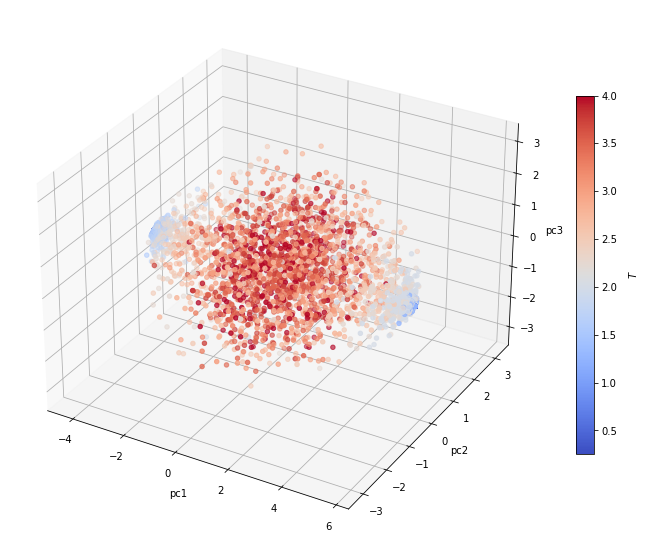

In [5]:
reducevec, vari = reduce_system(U, 3)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(reducevec[:, 0], reducevec[:, 1],
               reducevec[:, 2], c=t, cmap="coolwarm")

ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
cb = fig.colorbar(p, shrink=0.55)
cb.set_label(label='$T$', labelpad=10)
plt.show()


### (b) Perform K-mean clustering 

We perform K-mean clustering with 3 centroids, and plot the resulting clusters in different colors

In [6]:
def K_mean(pc, K=3, jmax=10):
    # step 1 - choose 3 clusters at random
    # step 2 - select random point as centroids
    a = random.sample(range(0, len(pc)-1), K)
    Centroids = np.zeros((K, 3))
    for i in range(K):
        Centroids[i, 0] = pc[a[i]][0]
        Centroids[i, 1] = pc[a[i]][1]
        Centroids[i, 2] = pc[a[i]][2]
    diff = 1
    j = 0
    Centroids = pd.DataFrame(Centroids)
    Centroids.columns = ['pc1', 'pc2', 'pc3']
    principalComponents = pd.DataFrame(pc)
    principalComponents.columns = ['pc1', 'pc2', 'pc3']
    while (diff != 0):
        XD = principalComponents
        i = 1
# step 3 - assign all the points to the closest cluster centroid
        for index1, row_c in Centroids.iterrows():
            ED = []
            for index2, row_d in XD.iterrows():
                d1 = (row_c["pc1"] - row_d["pc1"])**2
                d2 = (row_c["pc2"] - row_d["pc2"])**2
                d3 = (row_c["pc3"] - row_d["pc3"])**2
                d = np.sqrt(d1+d2+d3)
                ED.append(d)
            principalComponents[i] = ED
            i = i + 1

        C = []
        for index, row in principalComponents.iterrows():
            min_dist = row[1]
            pos = 1
            for i in range(K):
                if row[i+1] < min_dist:
                    min_dist = row[i+1]
                    pos = i + 1
            C.append(pos)
        principalComponents["Cluster"] = C
# step 4 - recomput centroids of newly formed clusters
        Centroids_new = principalComponents.groupby(
            ["Cluster"]).mean()[["pc3", "pc2", "pc1"]]
# step 5 - repeat 3 and 4
        if j == 0:
            diff = 1
            j = j+1
        elif j < jmax:
            diff = ((Centroids_new['pc3'] - Centroids['pc3'])**2).sum() + ((Centroids_new['pc2'] -
                                                                            Centroids['pc2'])**2).sum() + ((Centroids_new['pc1'] - Centroids['pc1'])**2).sum()
            j = j+1
        else:
            diff = ((Centroids_new['pc3'] - Centroids['pc3'])**2).sum() + ((Centroids_new['pc2'] -
                                                                            Centroids['pc2'])**2).sum() + ((Centroids_new['pc1'] - Centroids['pc1'])**2).sum()
            diff = 0
        Centroids = principalComponents.groupby(["Cluster"]).mean()[
            ["pc3", "pc2", "pc1"]]
    return principalComponents, Centroids


In [7]:
import random
K = 3
a = random.sample(range(0, len(reducevec)-1), K)
Centroids = np.zeros((K, 3))
# print(a)
for i in range(K):
    Centroids[i, 0] = reducevec[a[i], 0]
    Centroids[i, 1] = reducevec[a[i], 1]
    Centroids[i, 2] = reducevec[a[i], 2]

pc = reducevec.tolist()
Centroids = Centroids.tolist()
Centroids = pd.DataFrame(Centroids)

principalComponents, Centroids = K_mean(pc, 3)


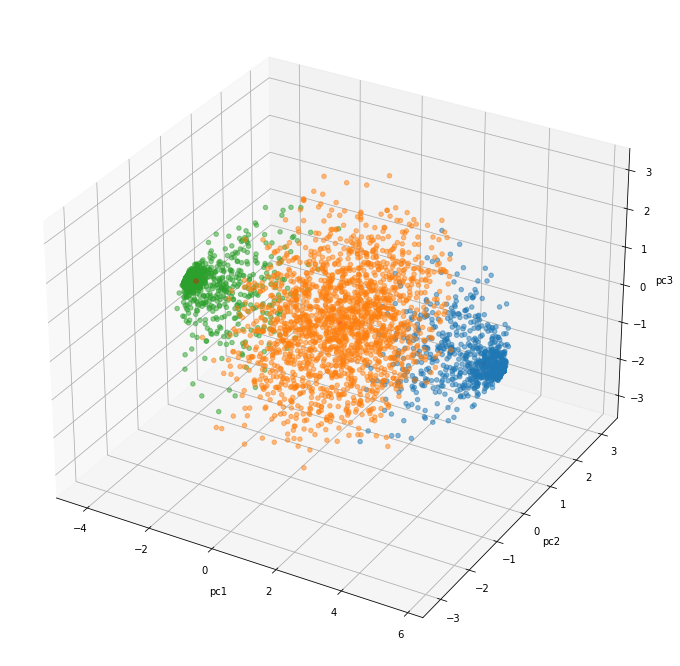

In [8]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

for k in range(K):
    data = principalComponents[principalComponents["Cluster"] == k+1]
    ax.scatter(data["pc1"], data["pc2"], data["pc3"], alpha=0.5)

ax.scatter(Centroids["pc1"], Centroids["pc2"], Centroids["pc3"], c='red')
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
plt.show()


### (c) Plot the distribution of eigenvalues

We plot the distribution of eigenvalues for the first two component as heat map on
the $ 10 \times 10 $ lattice.

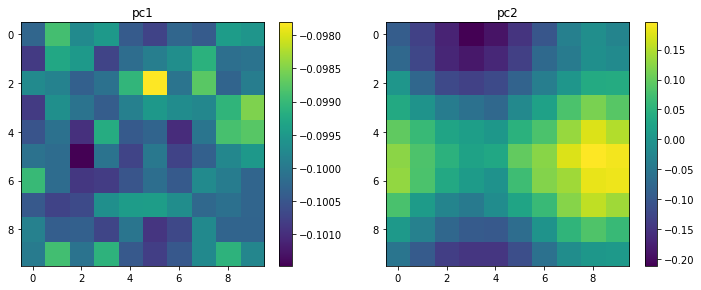

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
ax1, ax2 = axes

im1 = ax1.imshow(U[:, 0].reshape(10, 10))
im2 = ax2.imshow(U[:, 1].reshape(10, 10))

fig.colorbar(im1, ax=ax1, shrink=0.75)
fig.colorbar(im2, ax=ax2, shrink=0.75)
ax1.set_title('pc1')
ax2.set_title('pc2')
plt.show()


## 2. Theoretical aspect of 2D Ising Model

We consider Ising model in infinite size (L=6, 8, 10).

In [10]:
# spin configurations
L6 = pd.read_csv(
    "./PHYS3151-Machine-Learning-in-Physics-2023/principal-component-analysis/Ising_model/F_conf_L6.csv", header=None)
L8 = pd.read_csv(
    "./PHYS3151-Machine-Learning-in-Physics-2023/principal-component-analysis/Ising_model/F_conf_L8.csv", header=None)
L10 = pd.read_csv(
    "./PHYS3151-Machine-Learning-in-Physics-2023/principal-component-analysis/Ising_model/F_conf_L10.csv", header=None)
# temperature
t = pd.read_csv(
    "./PHYS3151-Machine-Learning-in-Physics-2023/principal-component-analysis/Ising_model/F_temp.csv", header=None)

L6 = L6.to_numpy()
L8 = L8.to_numpy()
L10 = L10.to_numpy()
t = t.to_numpy()


### (a) The magnetization of all systems at different temperatures

In [11]:
def group_avg(arr):
    # Calculate m, then group by t and take average
    m = np.c_[abs(arr.sum(axis=1)/arr.shape[1]), t]
    m = pd.DataFrame(m.tolist())
    m.columns = ['m', 't']
    m = m.groupby('t').mean().sort_values(by=['t'])
    return m


In [12]:
# Process data
arr6 = group_avg(L6)
arr8 = group_avg(L8)
arr10 = group_avg(L10)

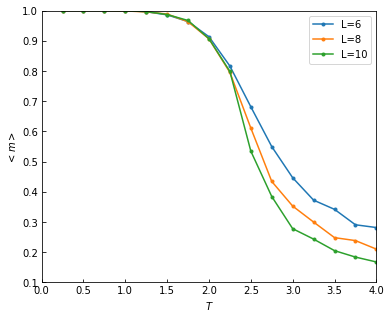

In [13]:
fig, ax = plt.subplots(figsize=(6, 5))

T = sorted(list(set(t[:, 0])))
ax.plot(T, arr6['m'], label='L=6', marker='.')
ax.plot(T, arr8['m'], label='L=8', marker='.')
ax.plot(T, arr10['m'], label='L=10', marker='.')

ax.set_xlim(0, T[-1])
ax.set_ylim(0.1, 1)
ax.set_xlabel('$T$')
ax.set_ylabel('$<m>$')
ax.tick_params(direction='in')
ax.legend()
plt.show()


### (b) Describe the trend and compare with the theoretical prediction
The plots above demonstrate that the magnetization as a function of temperature approach the theoretical prediction asymptotically as the system size increases.


